In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter, medfilt

# Constants

In [3]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

# Filter 

In [4]:
class LowPassFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=1500, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y

# Functions

In [5]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def get_processed_grf(grf, clip=False):
    singn_corrected = grf if np.mean(grf) > 0 else (-grf)
    processed_grf = LowPassFilter.apply(singn_corrected, fs=1500, cutoff=20)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 3, axis=0).T

def get_processed_moment(moment):
    processed_moment = LowPassFilter.apply(moment, fs=1500, cutoff=20)
    return resample(processed_moment, N_SAMPLES * 3, axis=0).T

def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 9:15, :]
        trajectory_y = content['data']['points'][1, 9:15, :]
        trajectory_z = content['data']['points'][2, 9:15, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 20:26, :]
        trajectory_y = content['data']['points'][1, 20:26, :]
        trajectory_z = content['data']['points'][2, 20:26, :]

    else:
        raise ValueError('Third foot is not allowed')

    # trajectory_x = LowPassFilter.apply(trajectory_x, fs=200, cutoff=20)
    # trajectory_y = LowPassFilter.apply(trajectory_y, fs=200, cutoff=20)
    # trajectory_z = LowPassFilter.apply(trajectory_z, fs=200, cutoff=20)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 3, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 3, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 3, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force(content):
    force_x = []
    force_y = []
    force_z = []
    for i in range(2):
        force_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_x, force_y, force_z

def get_moment(content):
    moment_x = []
    moment_y = []
    moment_z = []
    for i in range(2):
        moment_x.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][0, :]
            )
        )
        moment_y.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][1, :]
            )
        )
        moment_z.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][2, :]
            )
        )

    return moment_x, moment_y, moment_z

# Test Bench

In [13]:
path = '/home/ai/Python/GRF-Synthesis-from-Motion-Trajectories/Dataset/gait-dbase-1/2014001/2014001_C1_01.c3d'
content = c3d(path, extract_forceplat_data=True)

In [14]:
trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

force_x, force_y, force_z = get_force(content)

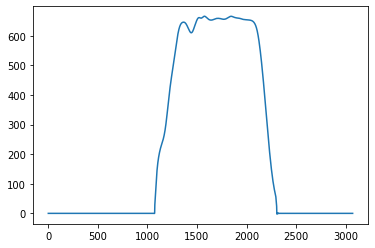

In [18]:
plt.plot(force_z[0])

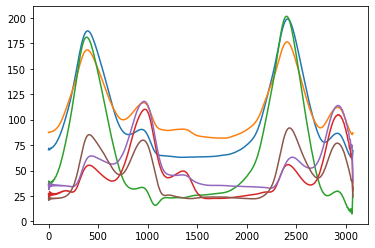

In [15]:
plt.plot(trajectory_z_l)

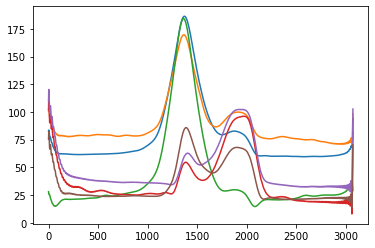

In [17]:
plt.plot(trajectory_z_r)

In [31]:
mask_force_z_1 = (force_z[0] > FORCE_THRESHOLD)
mask_force_z_2 = (force_z[1] > FORCE_THRESHOLD)

start_1 = np.min(np.argwhere(mask_force_z_1 == True))
end_1 = np.max(np.argwhere(mask_force_z_1 == True))

start_2 = np.min(np.argwhere(mask_force_z_2 == True))
end_2 = np.max(np.argwhere(mask_force_z_2 == True))

force_x_1 = force_x[0][start_1 : end_1]
force_y_1 = force_y[0][start_1 : end_1]
force_z_1 = force_z[0][start_1 : end_1]

force_x_2 = force_x[1][start_2 : end_2]
force_y_2 = force_y[1][start_2 : end_2]
force_z_2 = force_z[1][start_2 : end_2]

fm1_z_l = trajectory_z_l[:, 3]
fm1_z_r = trajectory_z_r[:, 3]

fm1_z_l_1 = fm1_z_l[start_1 : end_1]
fm1_z_l_2 = fm1_z_l[start_2 : end_2]

force_x_r = 0
force_y_r = 0
force_z_r = 0

force_x_l = 0
force_y_l = 0
force_z_l = 0

if np.mean(fm1_z_l_1) > np.mean(fm1_z_l_2):
    force_x_r = force_x_1
    force_y_r = force_y_1
    force_z_r = force_z_1

    force_x_l = force_x_2
    force_y_l = force_y_2
    force_z_l = force_z_2

    trajectory_x_r = trajectory_x_l[start_2 : end_2]
    trajectory_y_r = trajectory_y_r[start_2 : end_2]
    trajectory_z_r = trajectory_z_r[start_2 : end_2]

    trajectory_x_l = trajectory_x_r[start_1 : end_1]
    trajectory_y_l = trajectory_y_l[start_1 : end_1]
    trajectory_z_l = trajectory_z_l[start_1 : end_1]

else:
    force_x_l = force_x_1
    force_y_l = force_y_1
    force_z_l = force_z_1

    force_x_r = force_x_2
    force_y_r = force_y_2
    force_z_r = force_z_2

    trajectory_x_r = trajectory_x_l[start_1 : end_1]
    trajectory_y_r = trajectory_y_r[start_1 : end_1]
    trajectory_z_r = trajectory_z_r[start_1 : end_1]

    trajectory_x_l = trajectory_x_r[start_2 : end_2]
    trajectory_y_l = trajectory_y_l[start_2 : end_2]
    trajectory_z_l = trajectory_z_l[start_2 : end_2]

# ... Resample
trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

# ... Standardize
trajectory_x_r = standardize(trajectory_x_r)
trajectory_y_r = standardize(trajectory_y_r)
trajectory_z_r = standardize(trajectory_z_r)

trajectory_x_l = standardize(trajectory_x_l)
trajectory_y_l = standardize(trajectory_y_l)
trajectory_z_l = standardize(trajectory_z_l)

force_x_r = standardize(force_x_r)
force_y_r = standardize(force_y_r)
force_z_r = standardize(force_z_r)

force_x_l = standardize(force_x_l)
force_y_l = standardize(force_y_l)
force_z_l = standardize(force_z_l)

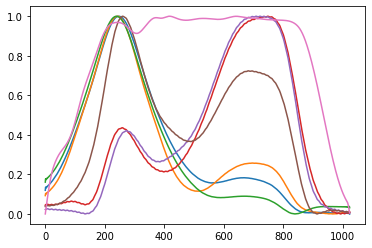

In [32]:
plt.plot(trajectory_z_r)
plt.plot(force_z_l)

# Extract Features

In [28]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        try:
            content = c3d(os.path.join(path, subject, filename), extract_forceplat_data=True)
            
            trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
            trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

            force_x, force_y, force_z = get_force(content)

            # ... Remove all zero GRF samples
            if np.sum(force_z[0]) <= FORCE_THRESHOLD or np.sum(force_z[1]) <= FORCE_THRESHOLD:
                # print(os.path.join(path, subject, filename))
                n_bad_samples = n_bad_samples + 1
                continue

            mask_force_z_1 = (force_z[0] > FORCE_THRESHOLD)
            mask_force_z_2 = (force_z[1] > FORCE_THRESHOLD)

            start_1 = np.min(np.argwhere(mask_force_z_1 == True))
            end_1 = np.max(np.argwhere(mask_force_z_1 == True))

            if (end_1 - start_1) < 500:
                n_bad_samples = n_bad_samples + 1
                continue

            start_2 = np.min(np.argwhere(mask_force_z_2 == True))
            end_2 = np.max(np.argwhere(mask_force_z_2 == True))

            if (end_2 - start_2) < 500:
                n_bad_samples = n_bad_samples + 1
                continue

            force_x_1 = force_x[0][start_1 : end_1]
            force_y_1 = force_y[0][start_1 : end_1]
            force_z_1 = force_z[0][start_1 : end_1]

            force_x_2 = force_x[1][start_2 : end_2]
            force_y_2 = force_y[1][start_2 : end_2]
            force_z_2 = force_z[1][start_2 : end_2]

            temp_r = trajectory_z_r[start_1 : end_1]
            temp_l = trajectory_z_l[start_1 : end_1]

            force_x_r = 0
            force_y_r = 0
            force_z_r = 0

            force_x_l = 0
            force_y_l = 0
            force_z_l = 0

            if np.sum(temp_l) > np.sum(temp_l):
                force_x_r = force_x_1
                force_y_r = force_y_1
                force_z_r = force_z_1

                force_x_l = force_x_2
                force_y_l = force_y_2
                force_z_l = force_z_2

                trajectory_x_r = trajectory_x_l[start_2 : end_2]
                trajectory_y_r = trajectory_y_r[start_2 : end_2]
                trajectory_z_r = trajectory_z_r[start_2 : end_2]

                trajectory_x_l = trajectory_x_r[start_1 : end_1]
                trajectory_y_l = trajectory_y_l[start_1 : end_1]
                trajectory_z_l = trajectory_z_l[start_1 : end_1]

            else:
                force_x_l = force_x_1
                force_y_l = force_y_1
                force_z_l = force_z_1

                force_x_r = force_x_2
                force_y_r = force_y_2
                force_z_r = force_z_2

                trajectory_x_r = trajectory_x_l[start_1 : end_1]
                trajectory_y_r = trajectory_y_r[start_1 : end_1]
                trajectory_z_r = trajectory_z_r[start_1 : end_1]

                trajectory_x_l = trajectory_x_r[start_2 : end_2]
                trajectory_y_l = trajectory_y_l[start_2 : end_2]
                trajectory_z_l = trajectory_z_l[start_2 : end_2]

            # ... Resample
            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

            force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
            force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
            force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

            force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
            force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
            force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

            # ... Standardize
            trajectory_x_r = standardize(trajectory_x_r)
            trajectory_y_r = standardize(trajectory_y_r)
            trajectory_z_r = standardize(trajectory_z_r)

            trajectory_x_l = standardize(trajectory_x_l)
            trajectory_y_l = standardize(trajectory_y_l)
            trajectory_z_l = standardize(trajectory_z_l)

            force_x_r = standardize(force_x_r)
            force_y_r = standardize(force_y_r)
            force_z_r = standardize(force_z_r)

            force_x_l = standardize(force_x_l)
            force_y_l = standardize(force_y_l)
            force_z_l = standardize(force_z_l)


                    
            _features_l = pd.DataFrame(
                np.concatenate([trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features_r = pd.DataFrame(
                np.concatenate([trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features = pd.concat([_features_l, _features_r], axis=0)

            _target_r = pd.DataFrame(
                np.stack([force_x_r, force_y_r, force_z_r], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target_l = pd.DataFrame(
                np.stack([force_x_l, force_y_l, force_z_l], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target = pd.concat([_target_r, _target_l], axis=0)

            features = pd.concat([features, _features], axis=0, ignore_index=True)
            target = pd.concat([target, _target], axis=0, ignore_index=True)

            records.append(filename)

            n_samples = n_samples + 1

        except Exception as e:
            print(f'ERROR [{subject}/{filename}]: {e}')
            n_bad_samples = n_bad_samples + 1
            pass


print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)


  0%|          | 0/50 [00:00<?, ?it/s]

ERROR [2015032/2015032_ST.c3d]: list index out of range


  2%|▏         | 1/50 [00:01<01:36,  1.97s/it]

ERROR [2014049/2014049_C5_04.c3d]: invalid number of data points (0) specified
ERROR [2014049/2014049_ST.c3d]: list index out of range
ERROR [2014049/2014049_C1_01.c3d]: invalid number of data points (0) specified
ERROR [2014049/2014049_C5_05.c3d]: invalid number of data points (0) specified
ERROR [2014049/2014049_C5_02.c3d]: invalid number of data points (0) specified


  4%|▍         | 2/50 [00:04<01:43,  2.16s/it]

ERROR [2014025/2014025_C3_05.c3d]: invalid number of data points (0) specified
ERROR [2014025/2014025_C5_04.c3d]: invalid number of data points (0) specified
ERROR [2014025/2014025_ST.c3d]: list index out of range


  6%|▌         | 3/50 [00:06<01:39,  2.12s/it]

ERROR [2015042/2015042_ST.c3d]: list index out of range
ERROR [2015042/2015042_C1_03.c3d]: invalid number of data points (0) specified
ERROR [2015042/2015042_C5_03.c3d]: invalid number of data points (0) specified
ERROR [2015042/2015042_C1_04.c3d]: invalid number of data points (0) specified


  8%|▊         | 4/50 [00:08<01:38,  2.14s/it]

ERROR [2014033/2014033_ST.c3d]: list index out of range
ERROR [2014033/2014033_C5_04.c3d]: invalid number of data points (0) specified
ERROR [2014033/2014033_C5_03.c3d]: invalid number of data points (0) specified


 10%|█         | 5/50 [00:10<01:28,  1.97s/it]

ERROR [2014046/2014046_C5_01.c3d]: invalid number of data points (0) specified
ERROR [2014046/2014046_ST.c3d]: list index out of range
ERROR [2014046/2014046_C1_01.c3d]: invalid number of data points (0) specified


 12%|█▏        | 6/50 [00:12<01:26,  1.96s/it]

ERROR [2015043/2015043_ST.c3d]: list index out of range


 16%|█▌        | 8/50 [00:16<01:23,  1.98s/it]

ERROR [2015030/2015030_ST.c3d]: list index out of range
ERROR [2015037/2015037_ST.c3d]: list index out of range


 18%|█▊        | 9/50 [00:17<01:17,  1.90s/it]

ERROR [2015027/2015027_C5_03.c3d]: invalid number of data points (0) specified
ERROR [2015027/2015027_ST.c3d]: list index out of range


 20%|██        | 10/50 [00:19<01:15,  1.90s/it]

ERROR [2015027/2015027_C5_02.c3d]: invalid number of data points (0) specified
ERROR [2014001/2014001_ST.c3d]: list index out of range


In [20]:
features

,fal_x,tam_x,fcc_x,fm1_x,fm2_x,fm5_x,fal_y,tam_y,fcc_y,fm1_y,fm2_y,fm5_y,fal_z,tam_z,fcc_z,fm1_z,fm2_z,fm5_z
0,0.891852,0.891695,0.892730,0.892732,0.892771,0.892760,0.041371,0.033575,0.973966,0.966037,0.954762,0.969560,0.026369,0.001309,0.056872,0.183351,0.064443,0.055629
1,0.939547,0.939392,0.940141,0.940140,0.940170,0.940164,0.045003,0.033802,1.000000,1.000000,1.000000,1.000000,0.017043,0.000000,0.013980,0.164771,0.000000,0.000000
2,0.973309,0.973180,0.973658,0.973656,0.973676,0.973673,0.043567,0.033301,0.986312,0.983446,0.979192,0.984189,0.020113,0.000807,0.029275,0.166825,0.026820,0.022045
3,0.993185,0.993109,0.993336,0.993334,0.993345,0.993344,0.044489,0.033138,0.991125,0.990434,0.989168,0.989910,0.017350,0.000609,0.017471,0.159252,0.011153,0.007929
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.043872,0.032756,0.983968,0.982193,0.979215,0.981688,0.018326,0.001050,0.023308,0.157991,0.023107,0.017339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,0.983143,0.983161,0.982913,0.982727,0.982705,0.982835,0.952428,0.956237,0.712746,0.944085,0.206300,0.013804,0.960192,0.355653,0.126747,0.676529,0.973988,0.383426
32764,0.968261,0.968269,0.968416,0.968269,0.968250,0.968355,0.946655,0.964572,0.724805,0.941414,0.200204,0.014831,0.950638,0.370162,0.143461,0.694316,0.965395,0.380208
32765,0.986223,0.986225,0.986531,0.986431,0.986417,0.986490,0.971594,0.972509,0.728149,0.967356,0.200914,0.007837,0.974348,0.363508,0.131042,0.703201,0.982640,0.383205
32766,0.960289,0.960288,0.960495,0.960441,0.960433,0.960473,0.954899,0.980431,0.742435,0.954882,0.193186,0.012135,0.954064,0.384608,0.156956,0.723780,0.965552,0.378072


In [21]:
target

,fx,fy,fz
0,0.555804,0.213348,0.000000
1,0.558452,0.205600,0.010350
2,0.559338,0.201915,0.015041
3,0.561156,0.196083,0.022685
4,0.562498,0.191445,0.028569
...,...,...,...
32763,0.587954,0.516718,0.027976
32764,0.590347,0.512450,0.022238
32765,0.592335,0.511307,0.015419
32766,0.594272,0.506136,0.010637


# Verification

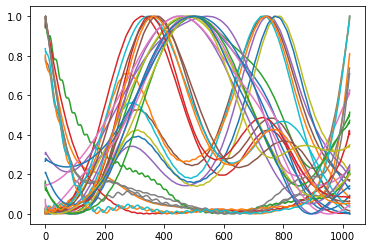

In [27]:
x = features['fm1_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

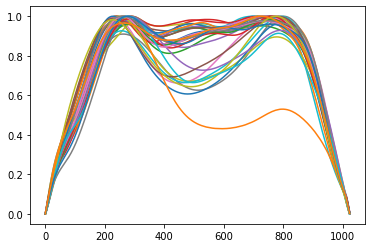

In [23]:
y = target['fz'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

In [13]:
path = '../../Dataset/Processed/data.joblib'
data = {
    'X': features,
    'y': target
}
# dump(data, path)

['../../Dataset/Processed/data.joblib']

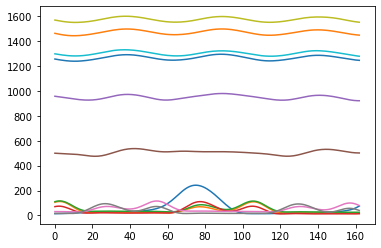

In [7]:
content = c3d('../../Dataset/gait-dbase-1/2015030/2015030_C5_02.c3d', extract_forceplat_data=True)
force_z_1 = content['data']['platform'][0]['force'][2, :]
force_z_2 = content['data']['platform'][1]['force'][2, :]
trajectory_z_l = content['data']['points'][2, 9:15, :]
trajectory_z_r = content['data']['points'][2, 20:26, :]

plt.plot(trajectory_z_l.T)
plt.plot(trajectory_z_r.T)

# plt.legend(['Left', 'Right'])

In [15]:
data_n = load(path)
X = data_n['X']
y = data_n['y']

fz = y['fz'].to_numpy().reshape(-1, N_SAMPLES)

 ...]

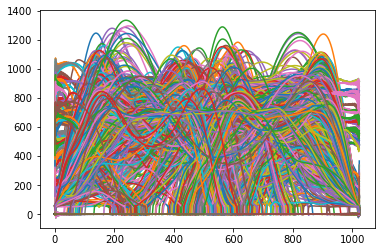

In [16]:
plt.plot(fz.T)

In [10]:
fz

array([[ 3.59400886e+01,  6.01235840e+01,  6.37500314e+01, ...,
         2.60220184e-01, -2.36760592e+00,  6.79199797e+00],
       [-2.97547417e-04, -1.76402491e+00,  1.04486871e+00, ...,
         6.61699891e+01,  5.47309059e+01,  2.36463758e+01],
       [ 4.07587161e+01,  6.31470825e+01,  6.66511826e+01, ...,
         5.51064072e-01, -3.45879293e+00,  8.42153590e+00],
       ...,
       [ 1.30053853e-02, -5.41071178e+00,  5.07632936e+00, ...,
         5.47783382e+01,  6.28422512e+01,  4.47772041e+01],
       [-1.01868828e-02, -3.18345541e+00,  1.74316801e+00, ...,
         5.80543643e+01,  5.19141866e+01,  2.51429411e+01],
       [ 2.82363585e+01,  5.63951181e+01,  6.63227550e+01, ...,
         4.93360730e-02, -6.57522723e-01,  4.64444127e+00]])